In [1]:
## Import dependencies to run example ##
%matplotlib notebook
import os
import sys
sys.path.append('..')
from models.som import SOM
from datasets.datasets import Datasets
import torch.backends.cudnn as cudnn
import random
from torch.utils.data.dataloader import DataLoader
import argparse
import metrics
from models.cnn_mnist import Net
import torch.optim as optim
import torch
import torch.nn as nn
from utils import utils
from utils.plot import *
from datetime import datetime
from os.path import join
from sampling.custom_lhs import *
import cudf
from cuml.manifold import TSNE as cumlTSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Weighted MSE Loss used to backpropagate unsupervised SOM error
def weightedMSELoss(output, target, relevance):
    return torch.sum(relevance * (output - target) ** 2)

In [3]:
## Train full model import CNN and SOM models and combine it in Net
def train_full_model(root, dataset_path, device, use_cuda,
                     epochs, n_samples, lr_cnn, som_input, debug):

    ## Load dataset
    dataset = Datasets(dataset=dataset_path, root_folder=root, debug=debug, n_samples=n_samples)

    ## Load Plotter
    som_plotter = Plotter()

    ## Load network passing parameters
    model = Net(d_in=dataset.d_in, ## Dataset d_in is the initial depth to calculate first convolutional layer
                n_conv_layers=2, ## Number of convolutional layers
                max_pool=True, ## Max Pooling activate with filters (2x2)
                hw_in=dataset.hw_in, ## Dataset hw_in is the size of input image (mnist: 28) to calculate hw after every layer
                som_input=som_input, ## Som input size (default: 2) because of plot
                filters_list=2, ## Initial index of power to create convolutional filters (power(2,2), power(2,3)) ...
                kernel_size_list=[5,5], ## Kernel size (5x5, 5x5)
                stride_size_list=[1,1], ## Stride size (1x1, 1x1)
                padding_size_list=[0,0], ## Padding size(0x0, 0x0)
                max_pool2d_size=2, ## Create a max pool with filters (2x2)
                n_max=n_max, ## Number max of nodes that the SOM model can create
                at=at, ## Threshold of activation of SOM nodes (High at update nodes, low at create new nodes)
                eb=eb, ## Learning rate of SOM model
                ds_beta=ds_beta, ## Parameter to pertubate the update of the moving average
                eps_ds=eps_ds, ## Parameter to change the decay of relevances
                device=device)
    
    manual_seed = 1 ## Seed to reproduce experiments
    random.seed(manual_seed)
    torch.manual_seed(manual_seed)

    if use_cuda:
        torch.cuda.manual_seed_all(manual_seed)
        model.cuda()
        cudnn.benchmark = True

    ## Load train and test datasets
    train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test_data, shuffle=False)

    ## Create optimizer to backpropagate loss
    optimizer = optim.Adam(model.parameters(), lr=lr_cnn)
    loss = nn.MSELoss(reduction='sum')

    model.train()
    for epoch in range(epochs):

        ## Self-Organize (Make SOM warm-up to data withou backpropagate it)
        for batch_idx, (sample, target) in enumerate(train_loader):
            sample, target = sample.to(device), target.to(device)
            model(sample)

        ## Self-Organize and Backpropagate
        avg_loss = 0
        s = 0
        for batch_idx, (sample, target) in enumerate(train_loader):

            ## Get sample and target, and zero_grad the optimizer
            sample, target = sample.to(device), target.to(device)
            optimizer.zero_grad()
            
            ## Pass the sample in the model, and get samples and respective prototypes to calculate the loss
            samples_high_at, weights_unique_nodes_high_at, relevances = model(sample)

            ##  If only new nodes were created, the loss is zero, no need to backprobagate it
            if len(samples_high_at) > 0:
                weights_unique_nodes_high_at = weights_unique_nodes_high_at.view(-1, model.som_input_size)
                out = weightedMSELoss(samples_high_at, weights_unique_nodes_high_at, relevances)
                out.backward()
                optimizer.step()
            else:
                out = 0.0

            avg_loss += out
            s += len(sample)

        samples = None
        t = None

        ##  Calculate metrics or plot without change SOM map
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model.cnn_extract_features(inputs)

            if samples is None:
                samples = outputs.cpu().detach().numpy()
                t = targets.cpu().detach().numpy()
            else:
                samples = np.append(samples, outputs.cpu().detach().numpy(), axis=0)
                t = np.append(t, targets.cpu().detach().numpy(), axis=0)

        centers, relevances, ma = model.som.get_prototypes()
        som_plotter.plot_data(samples, t, centers.cpu(), relevances.cpu()*0.1)
        print("Epoch: %d avg_loss: %.6f\n" % (epoch, avg_loss/s))

    ##  Calculate some metrics
    model.eval()
    cluster_result, predict_labels, true_labels = model.cluster(test_loader)

    print("Train Finished", flush=True)
    print("Homogeneity: %0.3f" % metrics.cluster.homogeneity_score(true_labels, predict_labels))
    print("Completeness: %0.3f" % metrics.cluster.completeness_score(true_labels, predict_labels))
    print("V-measure: %0.3f" % metrics.cluster.v_measure_score(true_labels, predict_labels))
    print('{0} \tCE: {1:.3f}'.format(dataset_path,
                                     metrics.cluster.predict_to_clustering_error(true_labels, predict_labels)))


In [4]:
## Example parameters
cuda_flag = False # Flag to use or not cuda
workers = 0 # Number of cpu workers (use default: 0)
ngpu = 1 # Number of gpus (use default: 1)
root = '../raw-datasets/' # Root dataset folder (default: ../raw-datasets/)
dataset_path = 'mnist' # Dataset Path (default: Realdata/breast.arff)
batch_size = 1 # Batch size (default: 1)
manual_seed = 1 # Seed to reproduce experiments

## Warning to remember that you can run with cuda
if torch.cuda.is_available() and not cuda_flag:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

## If cuda is available and you pass the flag, you can use it!
use_cuda = torch.cuda.is_available() and cuda_flag

## Initialize cuda
if use_cuda:
    torch.cuda.init()

## Set the device to convert the model and samples to gpu
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [5]:
## SOM Parameters (The default parameters generate the best CE that we found in the breast dataset)
n_max = 145 # Number max of nodes that the SOM model can create
at = 0.81302 # Threshold of activation of SOM nodes (High at update nodes, low at create new nodes)
ds_beta = 0.029942 # Parameter to pertubate the update of the moving average
eb = 0.00720282 # Learning rate of SOM model
eps_ds = 1. # Parameter to change the decay of relevances
som_epochs = 4 # Epochs to run the model
epochs = som_epochs # Epochs to train the model
n_samples = 20 # Limit samples of the dataset to visualize and run it as a toy problem
lr_cnn = 0.00001 # Learning rate to update the weights of the cnn
som_input = 2 # SOM input dimension
debug = True  # Flag to run n_samples and plot it

<IPython.core.display.Javascript object>


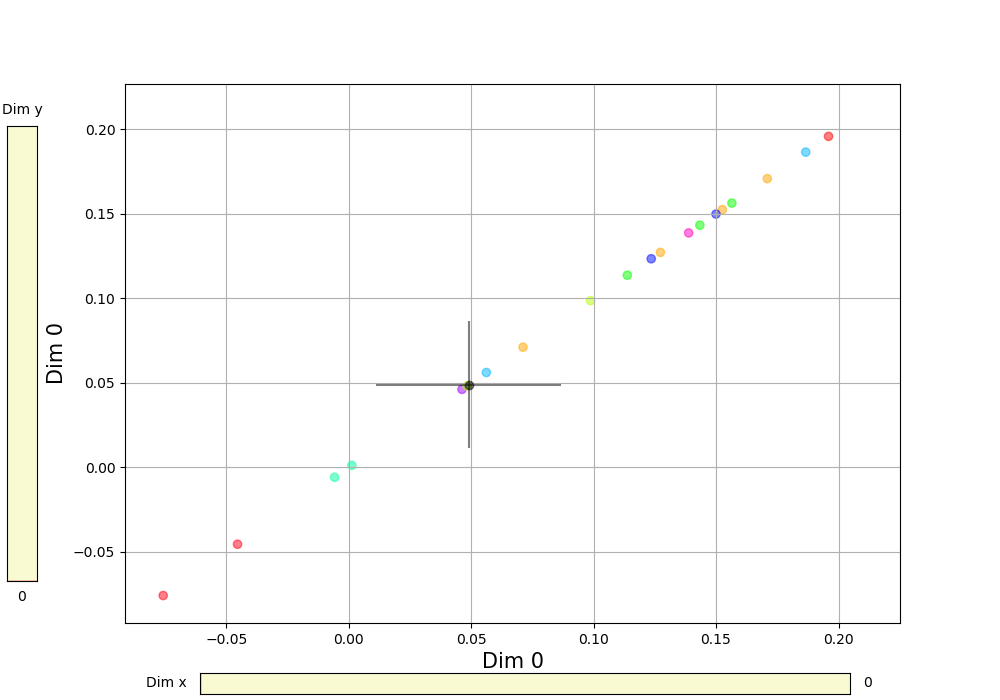

Epoch: 0 avg_loss: 0.011881

Epoch: 1 avg_loss: 0.008020

Epoch: 2 avg_loss: 0.006009

Epoch: 3 avg_loss: 0.004998

Train Finished
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
mnist 	CE: 0.200


In [6]:
train_full_model(root=root,
                 dataset_path=dataset_path, device=device,
                 use_cuda=use_cuda, epochs=epochs, n_samples=n_samples,
                 lr_cnn=lr_cnn, som_input=som_input, debug=debug)
